In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_sequences(data, day_of_week, hour, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = torch.cat([data[i:i+seq_length], day_of_week[i:i+seq_length], hour[i:i+seq_length]], dim=1)
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


df = pd.read_csv("data/reduced/June2022_reduced.csv")
df = df[df['Grid_ID'] == 16]  # Select a single grid
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)

# Resample the "C1" column for each hour and calculate the mean values
df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

# Create a new DataFrame with the mean values, Grid_ID, and Datetime
resampled_df = pd.DataFrame({
    "Grid_ID": df["Grid_ID"].resample("H").first(),
    "Datetime": df_hourly_mean.index,
    "C1": df_hourly_mean
})

# Add a new columns, might be useful later
resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
resampled_df["Hour"] = resampled_df["Datetime"].dt.hour
day_of_week_values = resampled_df["DayOfWeek"].values
day_of_week_tensor = torch.tensor(day_of_week_values, dtype=torch.float32).reshape(-1, 1)
hour_values = resampled_df["Hour"].values
hour_tensor = torch.tensor(hour_values, dtype=torch.float32).reshape(-1, 1)


target_col = 'C1'
target = resampled_df[target_col].values.reshape(-1, 1)
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


# Define sequence length and create sequences
sequence_length = 80
sequences, labels = create_sequences(target_tensor, day_of_week_tensor, hour_tensor, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42, shuffle=False)


# Initialize the model
input_size = 3 
hidden_size = 30
output_size = 1  # Predicting one value (C1)
model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)

    loss = criterion(outputs.squeeze(), y_train.squeeze()) 
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Making predictions
model.eval()
future = 60
num_test_sequences = len(X_test) - future
test_sequences = X_test[:num_test_sequences, :, :]
predicted_sequences = []
with torch.no_grad():
    for test_seq in test_sequences:
        base_seq = test_seq.unsqueeze(0).clone()
        predicted_seq = []
        next_day = base_seq[:, -1:, 1]
        for i in range(future):
            pred = model(base_seq)
            predicted_seq.append(pred.item())

            next_hour = (base_seq[:, -1:, 2] + 1) % 24
            if(next_hour == 0):
                next_day = (base_seq[:, -1:, 1] + 1) % 7
        
            next_value = torch.cat([pred.unsqueeze(2), next_day.unsqueeze(2), next_hour.unsqueeze(2)], dim=2)  # Include hour tensor
            base_seq = torch.cat([base_seq[:, 1:, :], next_value], dim=1)
        # Inverse transform the values
        predicted_seq = np.array(predicted_seq).reshape(-1, 1)
        predicted_seq = scaler.inverse_transform(predicted_seq)
        predicted_sequences.append(predicted_seq)


y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))
mae_list = []
rmse_list = []

for i in range(num_test_sequences):
    y_t = y_test[i:i+future]
    predicted_seq = predicted_sequences[i]
    mae = mean_absolute_error(y_t, predicted_seq)
    rmse = np.sqrt(mean_squared_error(y_t, predicted_seq))

    mae_list.append(mae)
    rmse_list.append(rmse)

average_mae = np.mean(mae_list)
average_rmse = np.mean(rmse_list)

print(f"Average Mean Absolute Error (MAE): {average_mae}")
print(f"Average Root Mean Squared Error (RMSE): {average_rmse}")

# Plot the results
test_start = len(target) - len(y_test)
seq_used_pred = scaler.inverse_transform(test_sequences[1, :,0].squeeze().reshape(-1, 1).clone())

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
plt.plot(np.arange(test_start - len(seq_used_pred), test_start),  np.array(seq_used_pred).reshape(-1, 1), label='X_test', color='gray')
plt.plot(np.arange(test_start, test_start + future), predicted_sequences[0], label='Predicted Data', color='green')

plt.xlabel('Time Steps')
plt.ylabel(target_col)
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/reduced/June2022_reduced.csv'

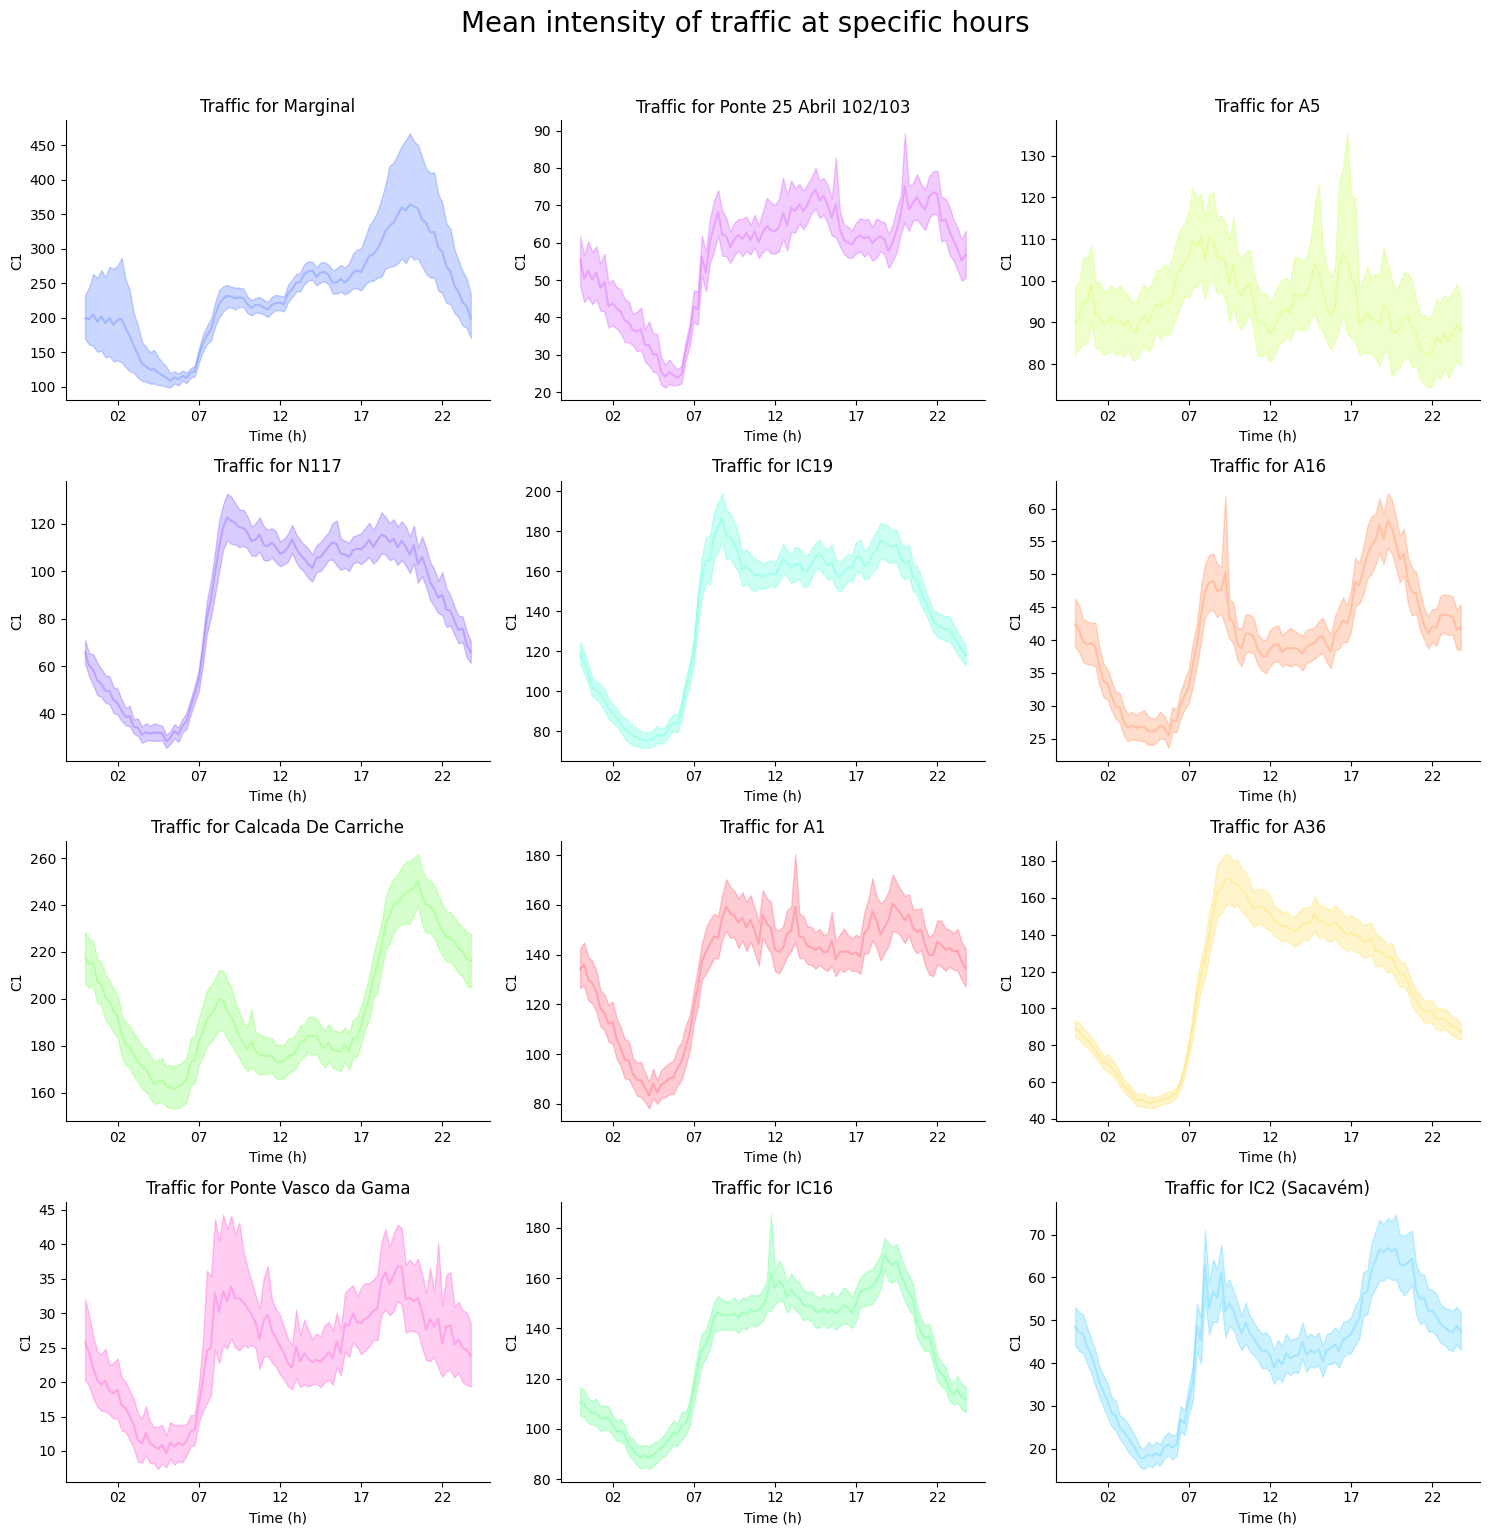

In [2]:
import cml
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import colormaps as cm
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates



vodafone_data = cml.VodafoneData()
main_roads_df = vodafone_data.read('data/reduced/subset') # Read the data from the folder (All Vodafone data)
vodafone_data.preprocess(main_roads_df)

columns = ['Grid_ID', 'Datetime', 'C1', 'C2', 'C11', 'E1', 'E7', 'E8', 'E9']
main_roads_df = main_roads_df[columns]

grids_df = pd.read_csv('data/wktComplete.csv', encoding='latin-1', index_col='grelha_id')
grids_df['geometry'] = grids_df.wkt.apply(wkt.loads)
grids_geo = gpd.GeoDataFrame(grids_df) 
grids_geo.sort_index(inplace=True)
grids_geo.set_crs(epsg=4326, inplace=True)
grids_geo.to_crs(epsg=3857, inplace=True)

entrance_roads_girds_id = [value for values in cml.street_names.values() for value in values]
entrance_roads_df = main_roads_df[main_roads_df.Grid_ID.isin(entrance_roads_girds_id)].copy()
entrance_roads_df.describe()


def assign_street_name(grid_id):
    for street, grid_ids in cml.street_names.items():
        if grid_id in grid_ids:
            return street
    return None

def cmap_to_dict(cmap, categories):
    return {category: cmap(i) for category, i in zip(categories, np.linspace(0, 1, len(categories)))}

grids_geo['street_name'] = grids_geo.index.map(assign_street_name)
grids_geo['street_name'] = grids_geo['street_name'].astype('category')
main_streets_grids_geo = grids_geo[grids_geo.street_name.notna()]
streets_cmap_name = 'gist_rainbow'
streets_cmap = cm.get_cmap(streets_cmap_name)
streets_cmap_dict = cmap_to_dict(streets_cmap, main_streets_grids_geo.street_name.cat.categories)

entrance_roads_df['street_name'] = entrance_roads_df.Grid_ID.map(assign_street_name)
entrance_roads_df['hour'] = entrance_roads_df.Datetime.dt.hour
entrance_roads_df['minute'] = entrance_roads_df.Datetime.dt.minute

# Get unique street names
street_names = entrance_roads_df['street_name'].unique()
num_subplots = len(street_names)
num_rows = num_subplots // 3 + (num_subplots % 3 > 0)
num_cols = min(num_subplots, 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Mean intensity of traffic at specific hours', fontsize=20, y=1.02)

# Plot separately for each street name
for ax, street_name in zip(axes.flatten(), street_names):
    street_df = entrance_roads_df[entrance_roads_df['street_name'] == street_name].copy()
    street_df.set_index('Datetime', inplace=True)
    street_df = street_df.resample('15T')[['C1']].mean()
    street_df['time'] = pd.to_datetime(street_df.index.time, format='%H:%M:%S')
    sns.lineplot(x='time', y='C1', data=street_df, legend=True, c=streets_cmap_dict[street_name], ax=ax, alpha=0.2)
    ax.set_xlabel('Time (h)')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    sns.despine()
    ax.set_title(f'Traffic for {street_name}')

plt.tight_layout()
plt.show()

Epoch [100/2000], Loss: 0.004465475678443909
Epoch [200/2000], Loss: 0.0028727177996188402
Epoch [300/2000], Loss: 0.0016181262908503413
Epoch [400/2000], Loss: 0.001290330197662115
Epoch [500/2000], Loss: 0.0011793492594733834
Epoch [600/2000], Loss: 0.001072388724423945
Epoch [700/2000], Loss: 0.0009571502450853586
Epoch [800/2000], Loss: 0.0008401478989981115
Epoch [900/2000], Loss: 0.0006721819518133998
Epoch [1000/2000], Loss: 0.0006371514173224568
Epoch [1100/2000], Loss: 0.0005634910194203258
Epoch [1200/2000], Loss: 0.0005228969384916127
Epoch [1300/2000], Loss: 0.0005008921143598855
Epoch [1400/2000], Loss: 0.00048793063615448773
Epoch [1500/2000], Loss: 0.000467529782326892
Epoch [1600/2000], Loss: 0.00045184517512097955
Epoch [1700/2000], Loss: 0.0004471998836379498
Epoch [1800/2000], Loss: 0.00044040268403477967
Epoch [1900/2000], Loss: 0.0004253603401593864
Epoch [2000/2000], Loss: 0.00040216572233475745
Street: Marginal
LSTM Model - Average Mean Absolute Error (MAE): 46.2

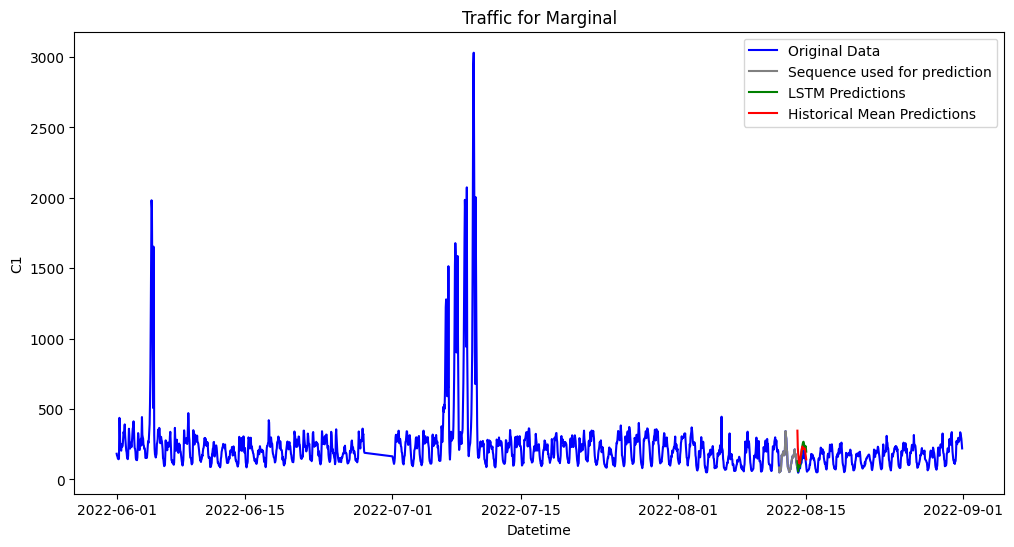

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


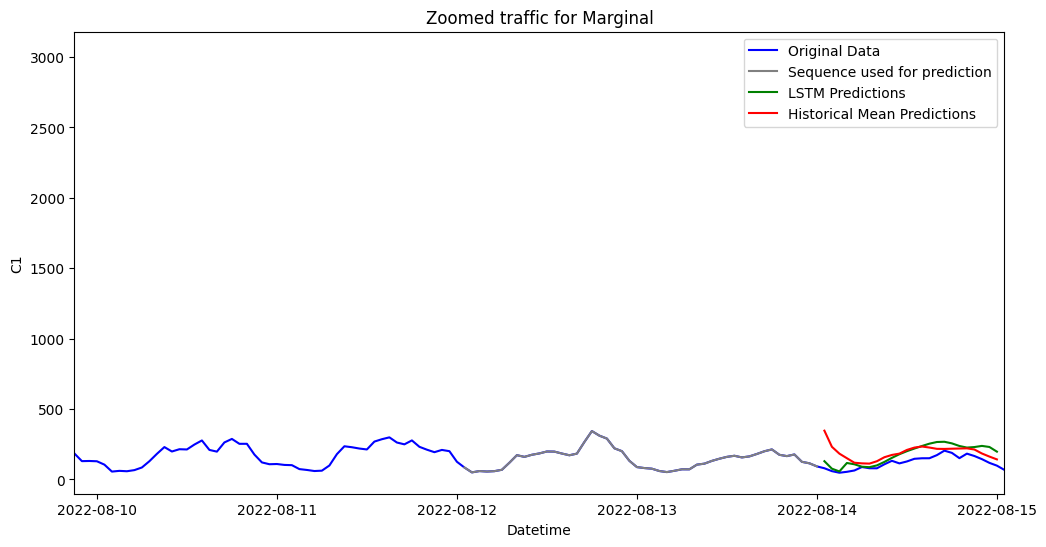

Epoch [100/2000], Loss: 0.005252314265817404
Epoch [200/2000], Loss: 0.0048956554383039474
Epoch [300/2000], Loss: 0.00460751261562109
Epoch [400/2000], Loss: 0.004193984903395176
Epoch [500/2000], Loss: 0.0030307190027087927
Epoch [600/2000], Loss: 0.0027980823069810867
Epoch [700/2000], Loss: 0.002689283574000001
Epoch [800/2000], Loss: 0.002633853117004037
Epoch [900/2000], Loss: 0.002603039611130953
Epoch [1000/2000], Loss: 0.002574223093688488
Epoch [1100/2000], Loss: 0.0025442512705922127
Epoch [1200/2000], Loss: 0.002514727646484971
Epoch [1300/2000], Loss: 0.002483365824446082
Epoch [1400/2000], Loss: 0.0024415371008217335
Epoch [1500/2000], Loss: 0.0024135378189384937
Epoch [1600/2000], Loss: 0.0023834824096411467
Epoch [1700/2000], Loss: 0.0023637348785996437
Epoch [1800/2000], Loss: 0.0023343702778220177
Epoch [1900/2000], Loss: 0.00232754647731781
Epoch [2000/2000], Loss: 0.002280490007251501
Street: Ponte 25 Abril 102/103
LSTM Model - Average Mean Absolute Error (MAE): 14.

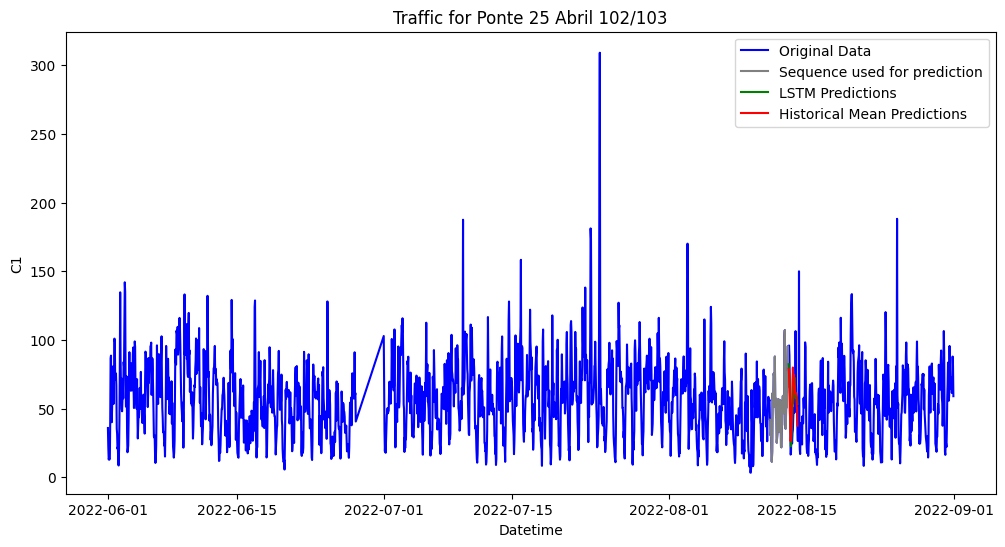

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


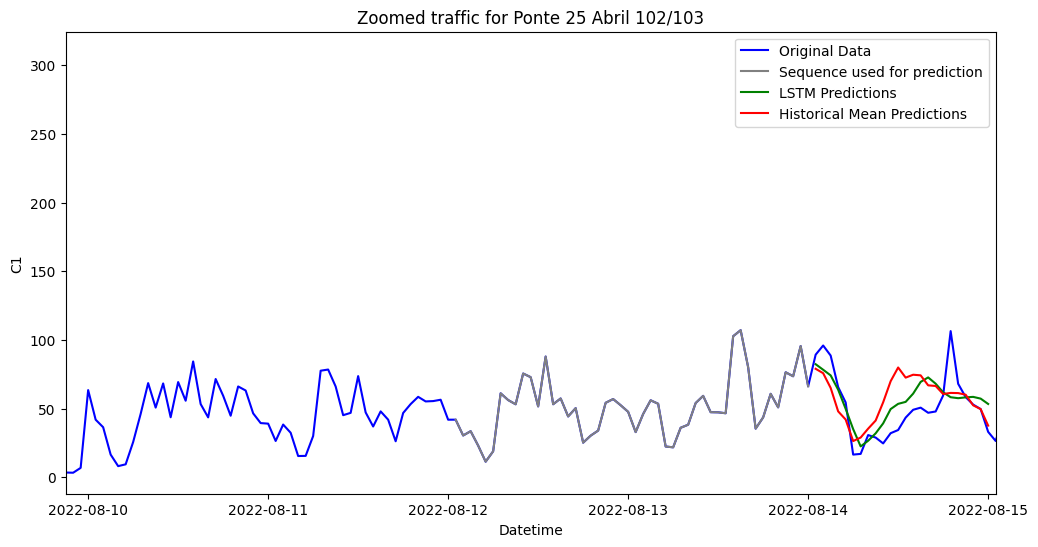

Epoch [100/2000], Loss: 0.0036216636653989553
Epoch [200/2000], Loss: 0.003343842923641205
Epoch [300/2000], Loss: 0.003076702356338501
Epoch [400/2000], Loss: 0.0026132070925086737
Epoch [500/2000], Loss: 0.0019587662536650896
Epoch [600/2000], Loss: 0.0017964835278689861
Epoch [700/2000], Loss: 0.0017136847600340843
Epoch [800/2000], Loss: 0.0016578355571255088
Epoch [900/2000], Loss: 0.0016063028015196323
Epoch [1000/2000], Loss: 0.0015543005429208279
Epoch [1100/2000], Loss: 0.0015005163149908185
Epoch [1200/2000], Loss: 0.0014491020701825619
Epoch [1300/2000], Loss: 0.0014094936195760965
Epoch [1400/2000], Loss: 0.0013850911054760218
Epoch [1500/2000], Loss: 0.0013710628263652325
Epoch [1600/2000], Loss: 0.0013622581027448177
Epoch [1700/2000], Loss: 0.0013545985566452146
Epoch [1800/2000], Loss: 0.0013467544922605157
Epoch [1900/2000], Loss: 0.0013372809626162052
Epoch [2000/2000], Loss: 0.0013247036840766668
Street: A5
LSTM Model - Average Mean Absolute Error (MAE): 27.458812809

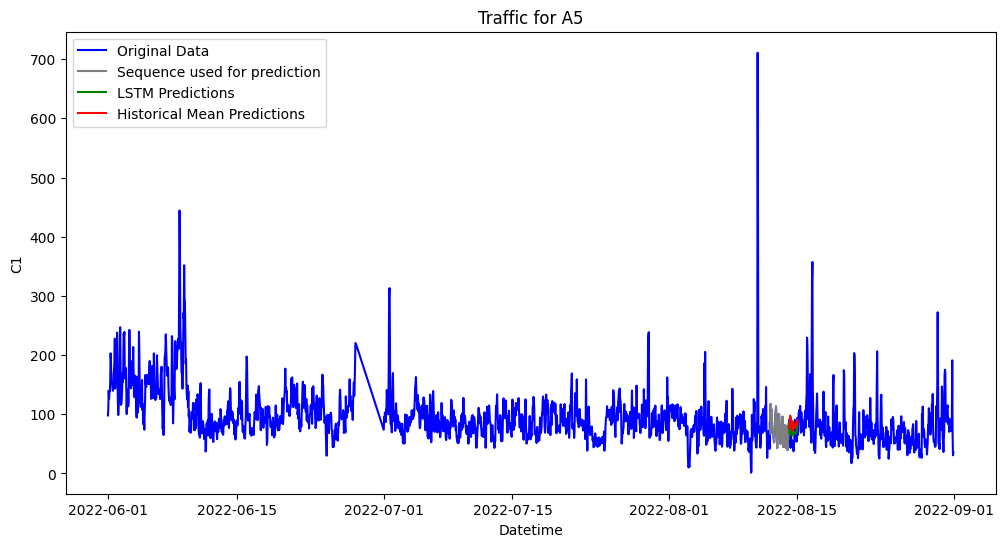

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


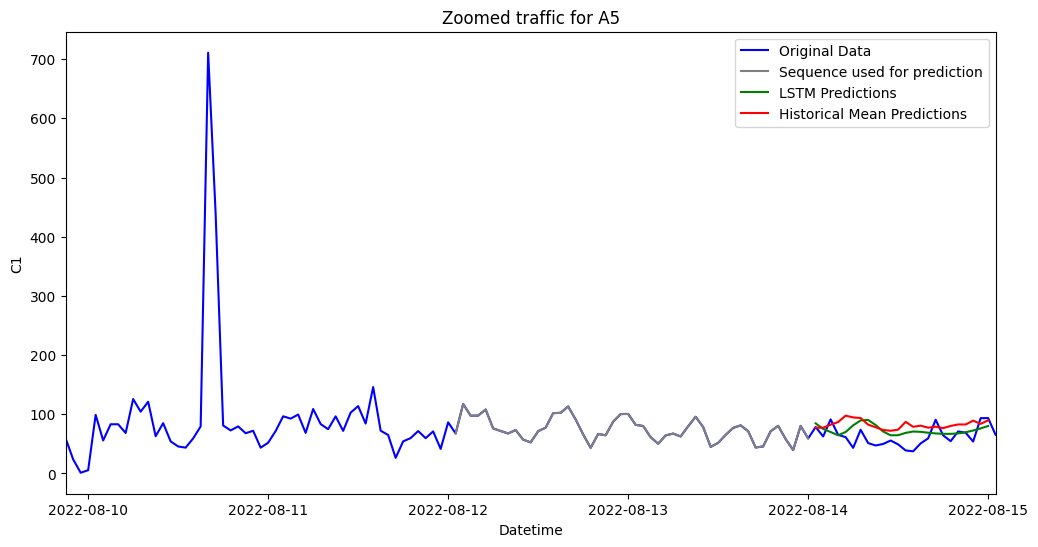

Epoch [100/2000], Loss: 0.011366737075150013
Epoch [200/2000], Loss: 0.009519184939563274
Epoch [300/2000], Loss: 0.007222641259431839
Epoch [400/2000], Loss: 0.006063487380743027
Epoch [500/2000], Loss: 0.00508931465446949
Epoch [600/2000], Loss: 0.004589889198541641
Epoch [700/2000], Loss: 0.004275345243513584
Epoch [800/2000], Loss: 0.004036576487123966
Epoch [900/2000], Loss: 0.0038612778298556805
Epoch [1000/2000], Loss: 0.0037401760928332806
Epoch [1100/2000], Loss: 0.003660144517198205
Epoch [1200/2000], Loss: 0.0036079685669392347
Epoch [1300/2000], Loss: 0.003553361166268587
Epoch [1400/2000], Loss: 0.0035056232009083033
Epoch [1500/2000], Loss: 0.0034602240193635225
Epoch [1600/2000], Loss: 0.0034185100812464952
Epoch [1700/2000], Loss: 0.0033806872088462114
Epoch [1800/2000], Loss: 0.003365750890225172
Epoch [1900/2000], Loss: 0.0033165989443659782
Epoch [2000/2000], Loss: 0.003273825393989682
Street: N117
LSTM Model - Average Mean Absolute Error (MAE): 16.559281440403453
LS

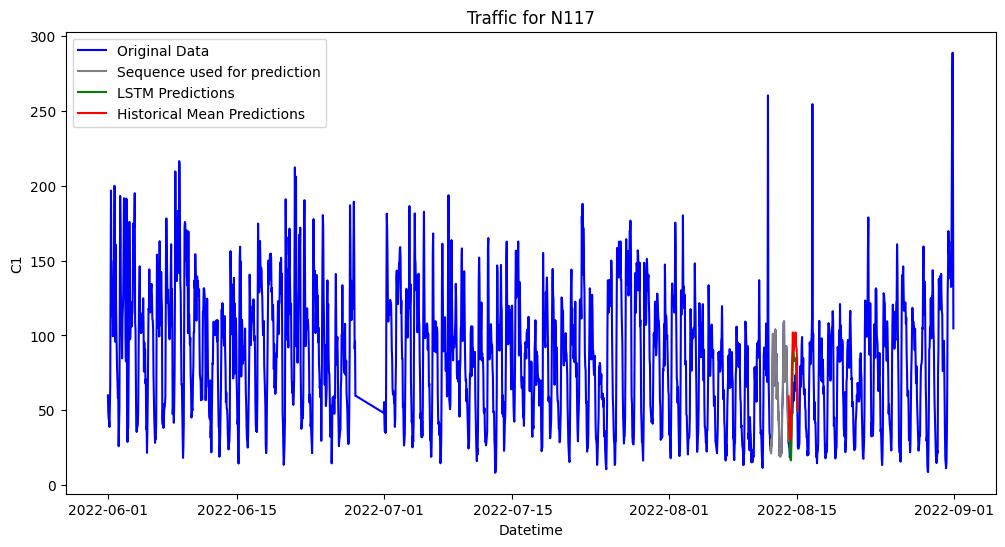

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


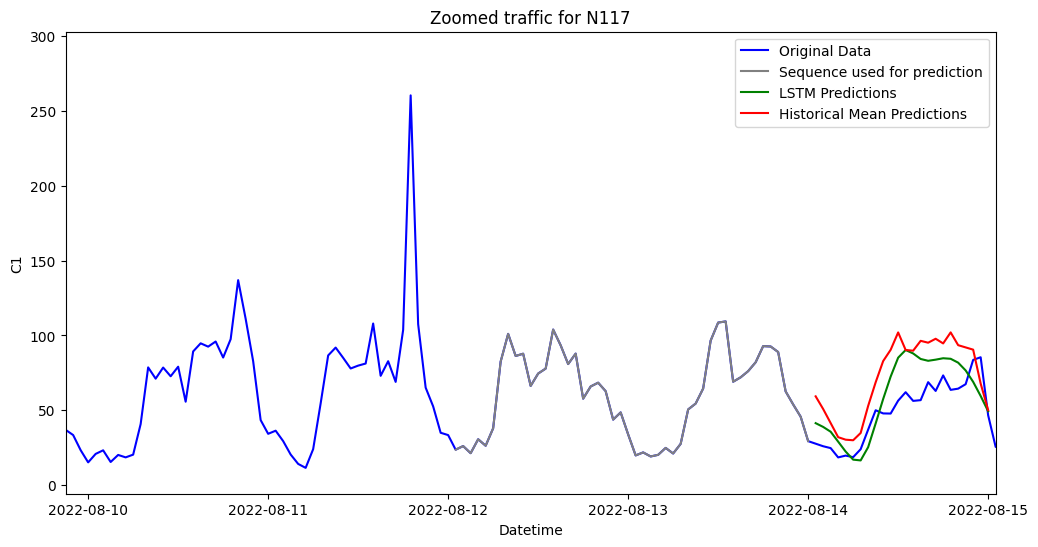

Epoch [100/2000], Loss: 0.014832339249551296
Epoch [200/2000], Loss: 0.009544255211949348
Epoch [300/2000], Loss: 0.006642183288931847
Epoch [400/2000], Loss: 0.005341457203030586
Epoch [500/2000], Loss: 0.004707610234618187
Epoch [600/2000], Loss: 0.004391867201775312
Epoch [700/2000], Loss: 0.0042160190641880035
Epoch [800/2000], Loss: 0.004098906647413969
Epoch [900/2000], Loss: 0.0040029301308095455
Epoch [1000/2000], Loss: 0.003899315372109413
Epoch [1100/2000], Loss: 0.003823524108156562
Epoch [1200/2000], Loss: 0.00374610279686749
Epoch [1300/2000], Loss: 0.003658539615571499
Epoch [1400/2000], Loss: 0.0036020679399371147
Epoch [1500/2000], Loss: 0.0035388132091611624
Epoch [1600/2000], Loss: 0.00349634001031518
Epoch [1700/2000], Loss: 0.003463656874373555
Epoch [1800/2000], Loss: 0.003408584278076887
Epoch [1900/2000], Loss: 0.003422725712880492
Epoch [2000/2000], Loss: 0.003362022340297699
Street: IC19
LSTM Model - Average Mean Absolute Error (MAE): 17.270594805048795
LSTM Mo

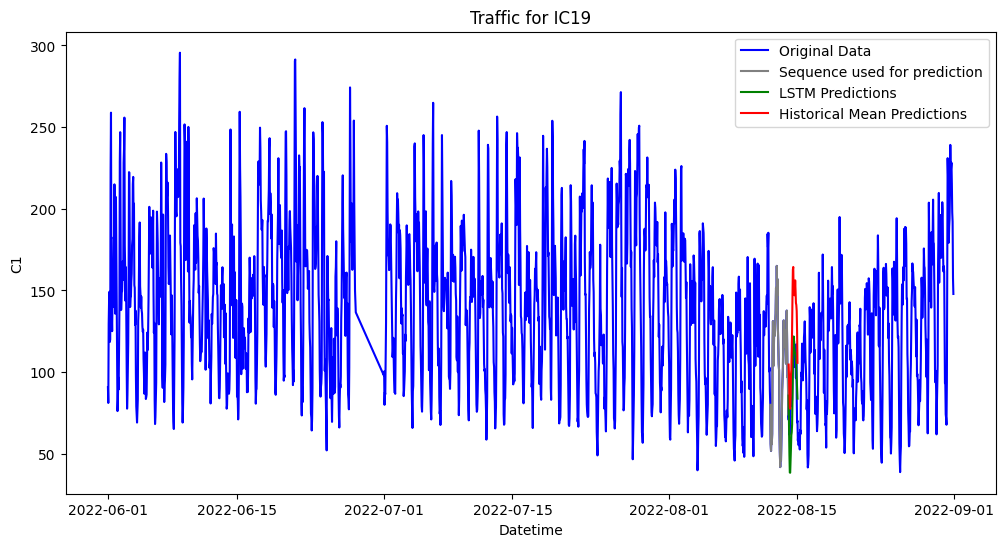

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


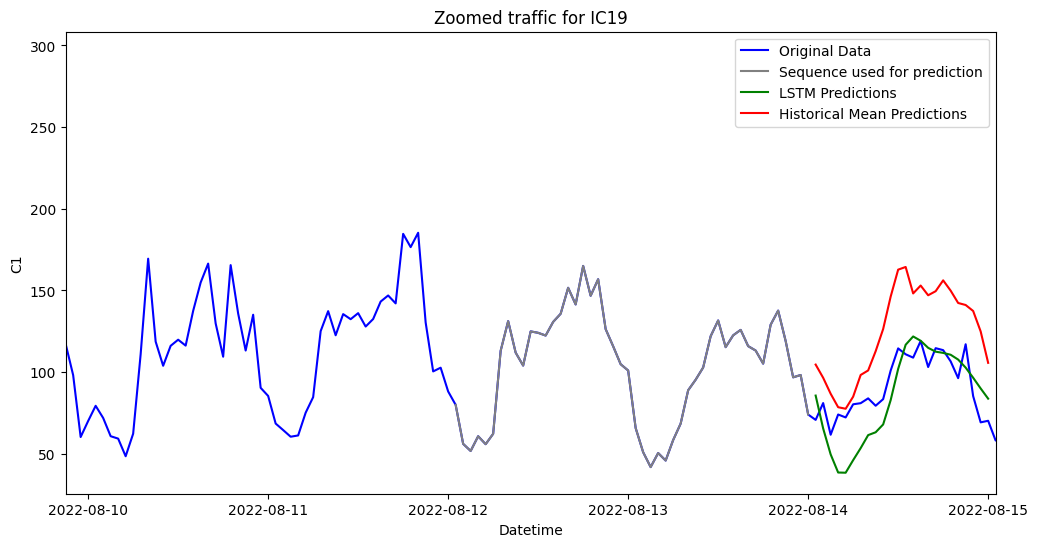

Epoch [100/2000], Loss: 0.005731272045522928
Epoch [200/2000], Loss: 0.005463961977511644
Epoch [300/2000], Loss: 0.0051673115231096745
Epoch [400/2000], Loss: 0.0047661359421908855
Epoch [500/2000], Loss: 0.004071701783686876
Epoch [600/2000], Loss: 0.003585528116673231
Epoch [700/2000], Loss: 0.0033253664150834084
Epoch [800/2000], Loss: 0.003116801381111145
Epoch [900/2000], Loss: 0.0029962181579321623
Epoch [1000/2000], Loss: 0.0029223740566521883
Epoch [1100/2000], Loss: 0.0028715080115944147
Epoch [1200/2000], Loss: 0.0028306415770202875
Epoch [1300/2000], Loss: 0.002817000960931182
Epoch [1400/2000], Loss: 0.002758417744189501
Epoch [1500/2000], Loss: 0.0027281453367322683
Epoch [1600/2000], Loss: 0.0027026087045669556
Epoch [1700/2000], Loss: 0.002665294799953699
Epoch [1800/2000], Loss: 0.0026350384578108788
Epoch [1900/2000], Loss: 0.0025993117596954107
Epoch [2000/2000], Loss: 0.0025804308243095875
Street: A16
LSTM Model - Average Mean Absolute Error (MAE): 8.187426296475573

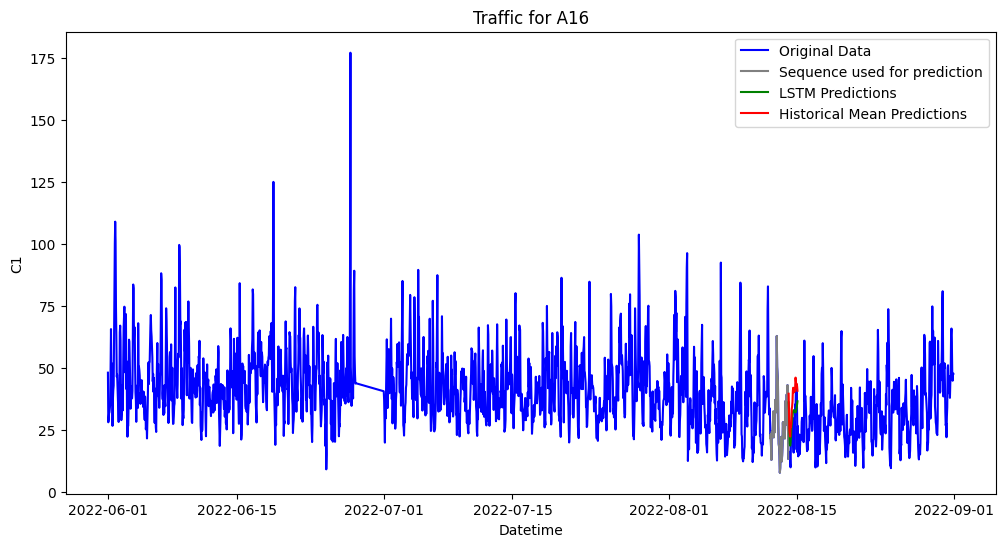

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


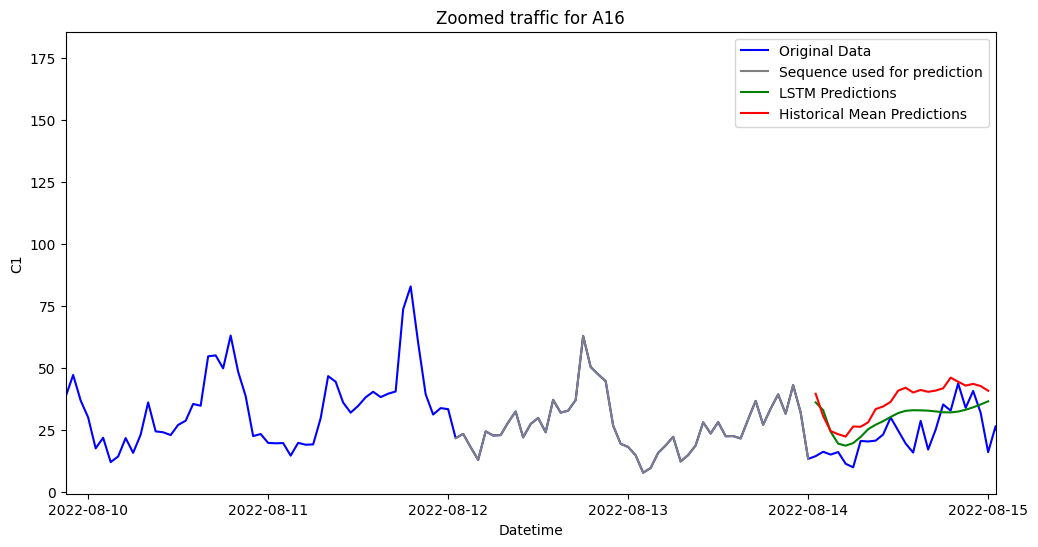

Epoch [100/2000], Loss: 0.01708398200571537
Epoch [200/2000], Loss: 0.01518155261874199
Epoch [300/2000], Loss: 0.011533577926456928
Epoch [400/2000], Loss: 0.007627197541296482
Epoch [500/2000], Loss: 0.006830960977822542
Epoch [600/2000], Loss: 0.005682545248419046
Epoch [700/2000], Loss: 0.004224682692438364
Epoch [800/2000], Loss: 0.0037037658039480448
Epoch [900/2000], Loss: 0.0033543806057423353
Epoch [1000/2000], Loss: 0.003116792067885399
Epoch [1100/2000], Loss: 0.0029948872979730368
Epoch [1200/2000], Loss: 0.002938266145065427
Epoch [1300/2000], Loss: 0.0028984027449041605
Epoch [1400/2000], Loss: 0.0028416102286428213
Epoch [1500/2000], Loss: 0.0027958075515925884
Epoch [1600/2000], Loss: 0.0027558188885450363
Epoch [1700/2000], Loss: 0.002717448165640235
Epoch [1800/2000], Loss: 0.002682398771867156
Epoch [1900/2000], Loss: 0.0026369064580649137
Epoch [2000/2000], Loss: 0.0026601175777614117
Street: Calcada De Carriche
LSTM Model - Average Mean Absolute Error (MAE): 24.196

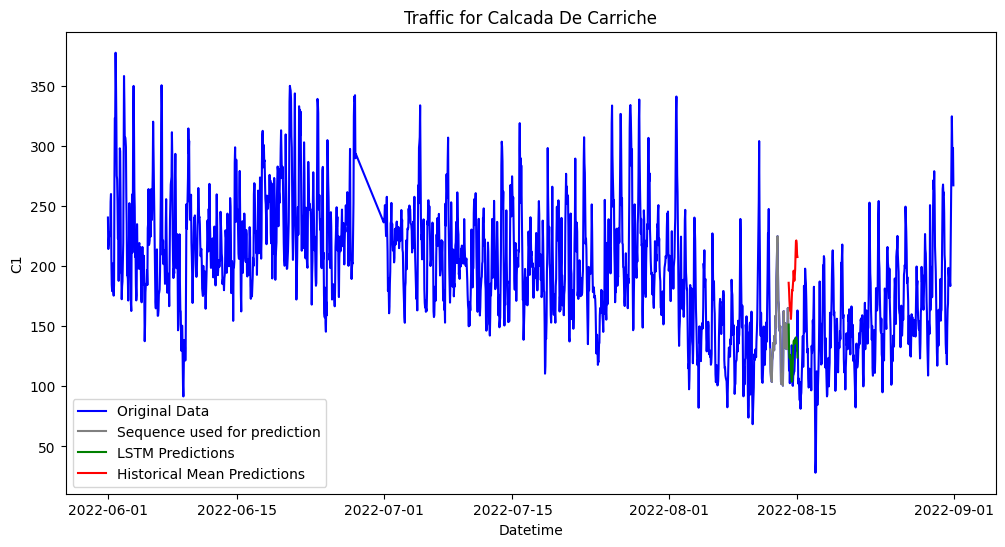

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


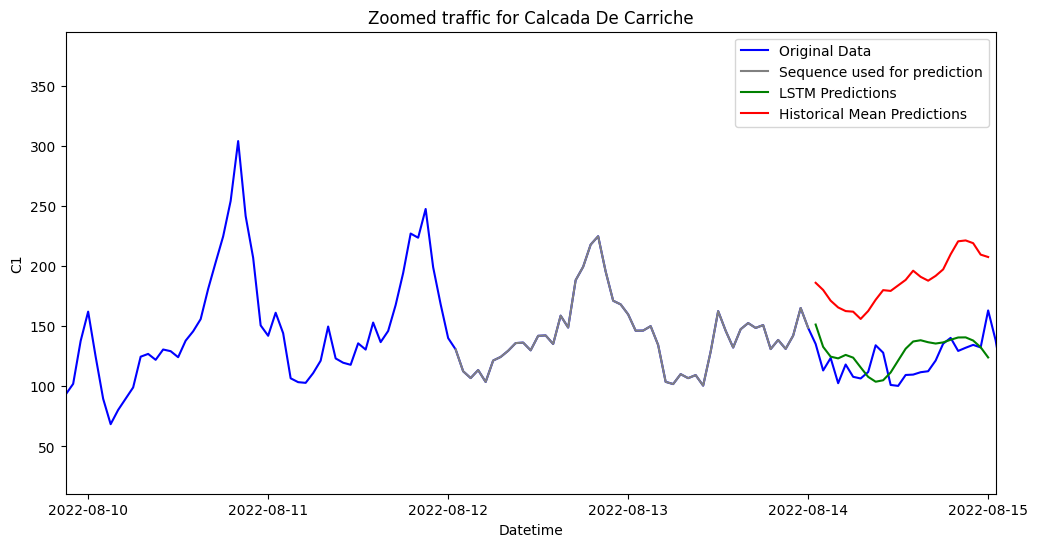

Epoch [100/2000], Loss: 0.006552443839609623
Epoch [200/2000], Loss: 0.004990604240447283
Epoch [300/2000], Loss: 0.004382416605949402
Epoch [400/2000], Loss: 0.004051494877785444
Epoch [500/2000], Loss: 0.0038646606262773275
Epoch [600/2000], Loss: 0.003771483665332198
Epoch [700/2000], Loss: 0.0037162508815526962
Epoch [800/2000], Loss: 0.003675163956359029
Epoch [900/2000], Loss: 0.003638075664639473
Epoch [1000/2000], Loss: 0.003601630451157689
Epoch [1100/2000], Loss: 0.003564856480807066
Epoch [1200/2000], Loss: 0.003547211177647114
Epoch [1300/2000], Loss: 0.003502231789752841
Epoch [1400/2000], Loss: 0.0035042534582316875
Epoch [1500/2000], Loss: 0.0034357262775301933
Epoch [1600/2000], Loss: 0.003398340428248048
Epoch [1700/2000], Loss: 0.0033423583954572678
Epoch [1800/2000], Loss: 0.0033175935968756676
Epoch [1900/2000], Loss: 0.0032467632554471493
Epoch [2000/2000], Loss: 0.003216845216229558
Street: A1
LSTM Model - Average Mean Absolute Error (MAE): 25.657009574384816
LSTM

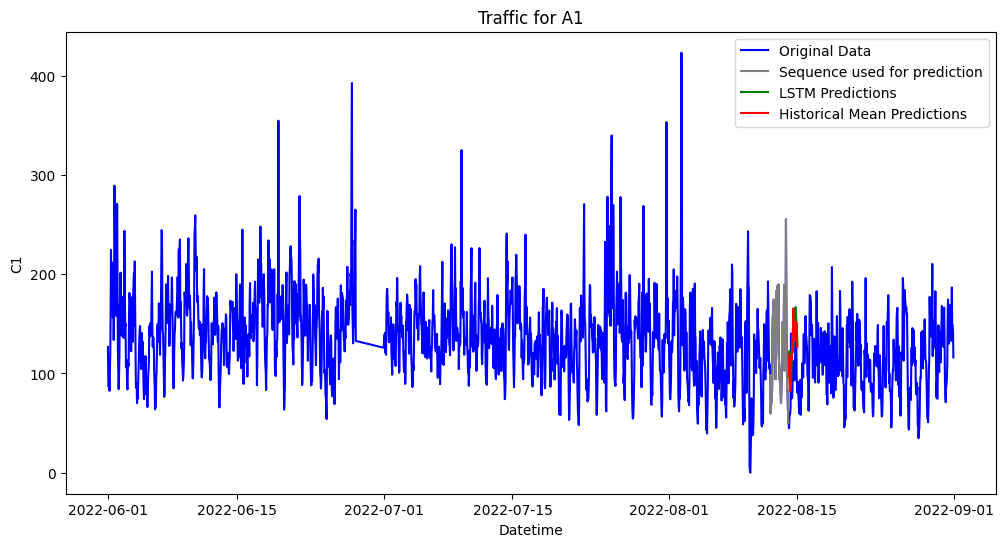

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


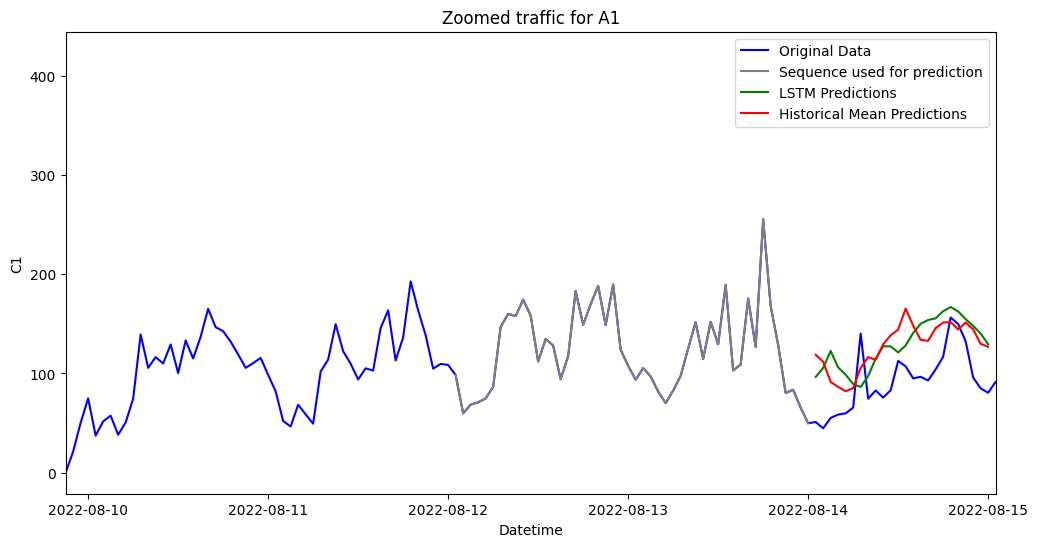

Epoch [100/2000], Loss: 0.01076508965343237
Epoch [200/2000], Loss: 0.00744133023545146
Epoch [300/2000], Loss: 0.00562916649505496
Epoch [400/2000], Loss: 0.004258427303284407
Epoch [500/2000], Loss: 0.00352736609056592
Epoch [600/2000], Loss: 0.003149136435240507
Epoch [700/2000], Loss: 0.0029306074138730764
Epoch [800/2000], Loss: 0.0028220321983098984
Epoch [900/2000], Loss: 0.0027623740024864674
Epoch [1000/2000], Loss: 0.0027144590858370066
Epoch [1100/2000], Loss: 0.0026716396678239107
Epoch [1200/2000], Loss: 0.002637577010318637
Epoch [1300/2000], Loss: 0.002610709983855486
Epoch [1400/2000], Loss: 0.0025784194003790617
Epoch [1500/2000], Loss: 0.002545626601204276
Epoch [1600/2000], Loss: 0.0025147811975330114
Epoch [1700/2000], Loss: 0.0024863036815077066
Epoch [1800/2000], Loss: 0.002456948161125183
Epoch [1900/2000], Loss: 0.002426683669909835
Epoch [2000/2000], Loss: 0.002405444160103798
Street: A36
LSTM Model - Average Mean Absolute Error (MAE): 20.87453234854174
LSTM Mo

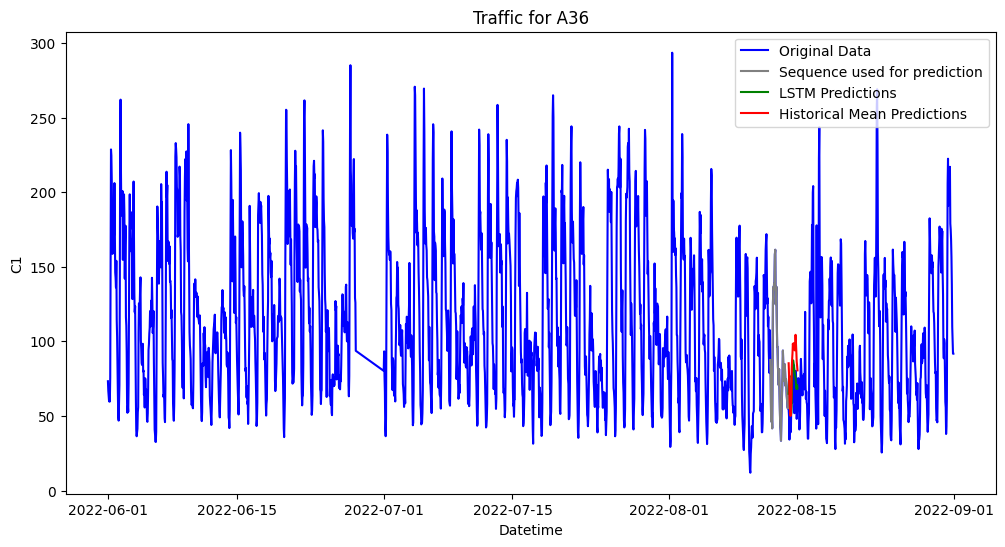

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


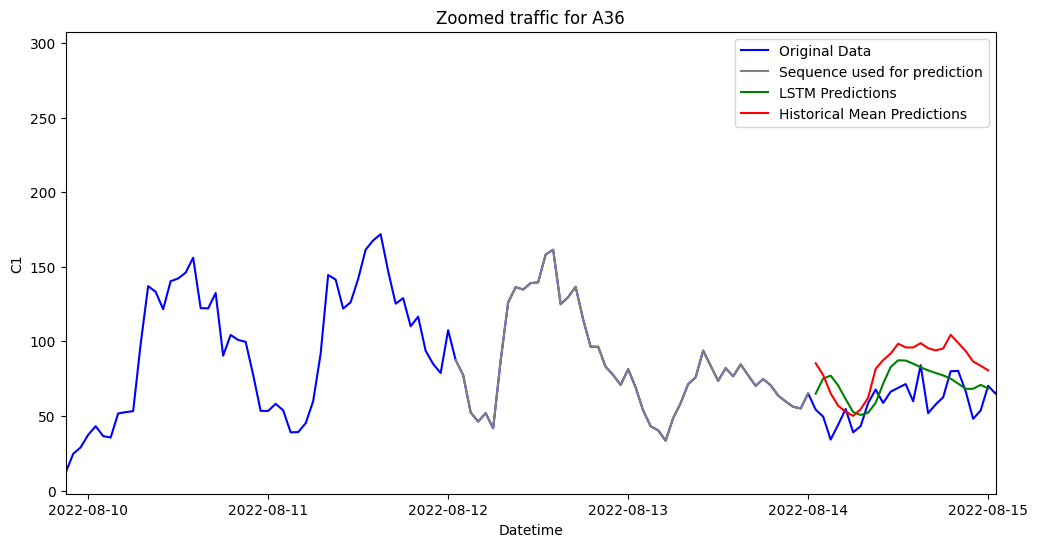

Epoch [100/2000], Loss: 0.003922691568732262
Epoch [200/2000], Loss: 0.003449025796726346
Epoch [300/2000], Loss: 0.0032381287310272455
Epoch [400/2000], Loss: 0.0030225201044231653
Epoch [500/2000], Loss: 0.002788582583889365
Epoch [600/2000], Loss: 0.0025365655310451984
Epoch [700/2000], Loss: 0.0022469284012913704
Epoch [800/2000], Loss: 0.0018183415522798896
Epoch [900/2000], Loss: 0.0014882759423926473
Epoch [1000/2000], Loss: 0.0014350460842251778
Epoch [1100/2000], Loss: 0.0013944836100563407
Epoch [1200/2000], Loss: 0.0013573264004662633
Epoch [1300/2000], Loss: 0.001322008902207017
Epoch [1400/2000], Loss: 0.0012860819697380066
Epoch [1500/2000], Loss: 0.0012466742191463709
Epoch [1600/2000], Loss: 0.0011988704791292548
Epoch [1700/2000], Loss: 0.0011334120063111186
Epoch [1800/2000], Loss: 0.001047604251652956
Epoch [1900/2000], Loss: 0.0009586308151483536
Epoch [2000/2000], Loss: 0.0008836336201056838
Street: Ponte Vasco da Gama
LSTM Model - Average Mean Absolute Error (MAE)

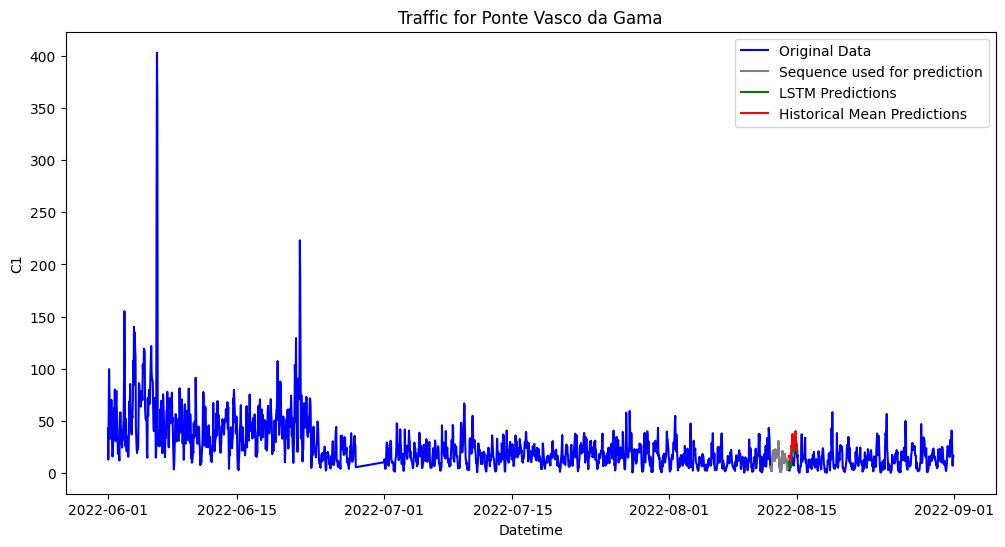

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


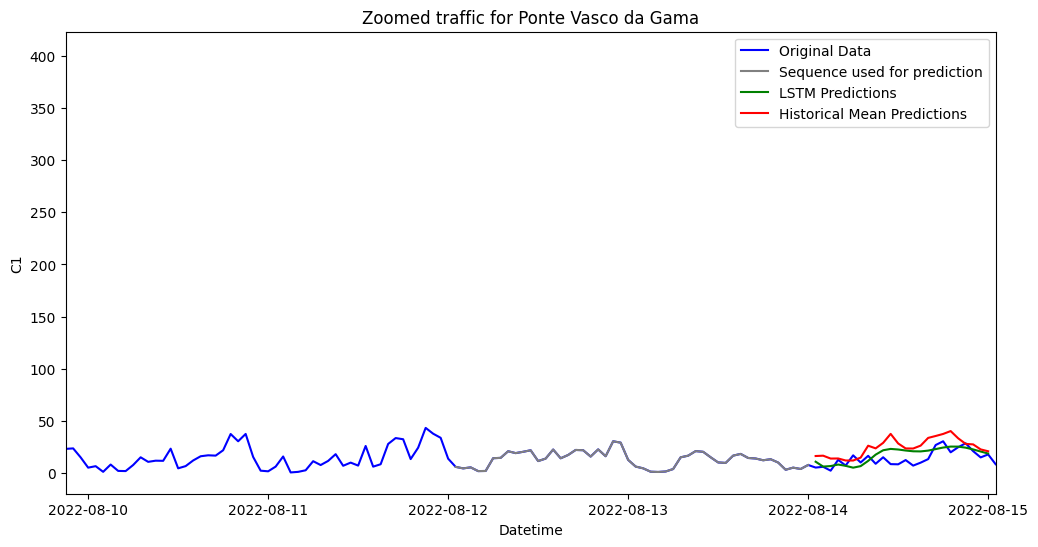

Epoch [100/2000], Loss: 0.007431270554661751
Epoch [200/2000], Loss: 0.006676626391708851
Epoch [300/2000], Loss: 0.005439537577331066
Epoch [400/2000], Loss: 0.004629955161362886
Epoch [500/2000], Loss: 0.004200026858597994
Epoch [600/2000], Loss: 0.003933841362595558
Epoch [700/2000], Loss: 0.003758448176085949
Epoch [800/2000], Loss: 0.003612867323681712
Epoch [900/2000], Loss: 0.0034903024788945913
Epoch [1000/2000], Loss: 0.003395303152501583
Epoch [1100/2000], Loss: 0.003318152390420437
Epoch [1200/2000], Loss: 0.003252018941566348
Epoch [1300/2000], Loss: 0.0032713788095861673
Epoch [1400/2000], Loss: 0.0031369912903755903
Epoch [1500/2000], Loss: 0.0030847196467220783
Epoch [1600/2000], Loss: 0.0030385868158191442
Epoch [1700/2000], Loss: 0.002977589378133416
Epoch [1800/2000], Loss: 0.0029260190203785896
Epoch [1900/2000], Loss: 0.0028803462628275156
Epoch [2000/2000], Loss: 0.002878050087019801
Street: IC16
LSTM Model - Average Mean Absolute Error (MAE): 21.100459007201785
LS

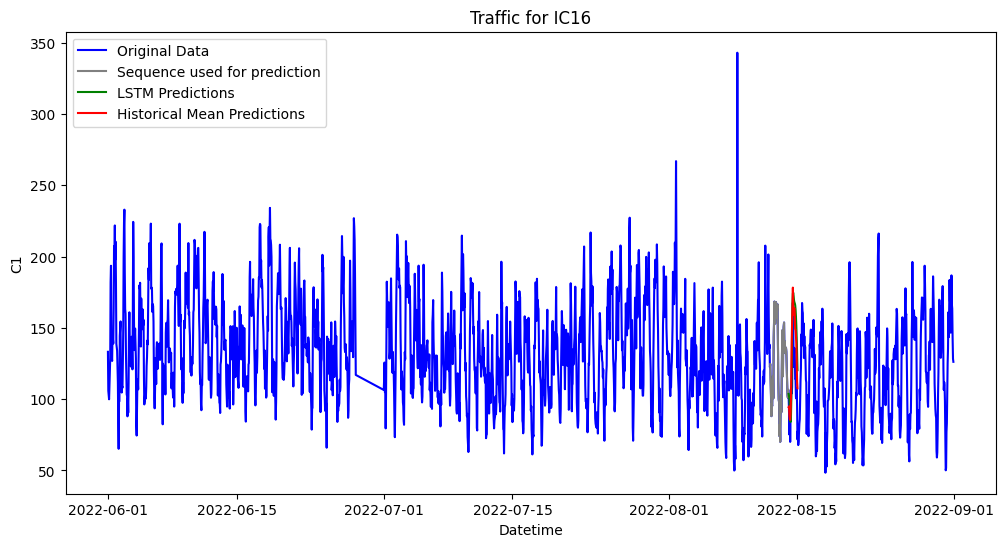

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


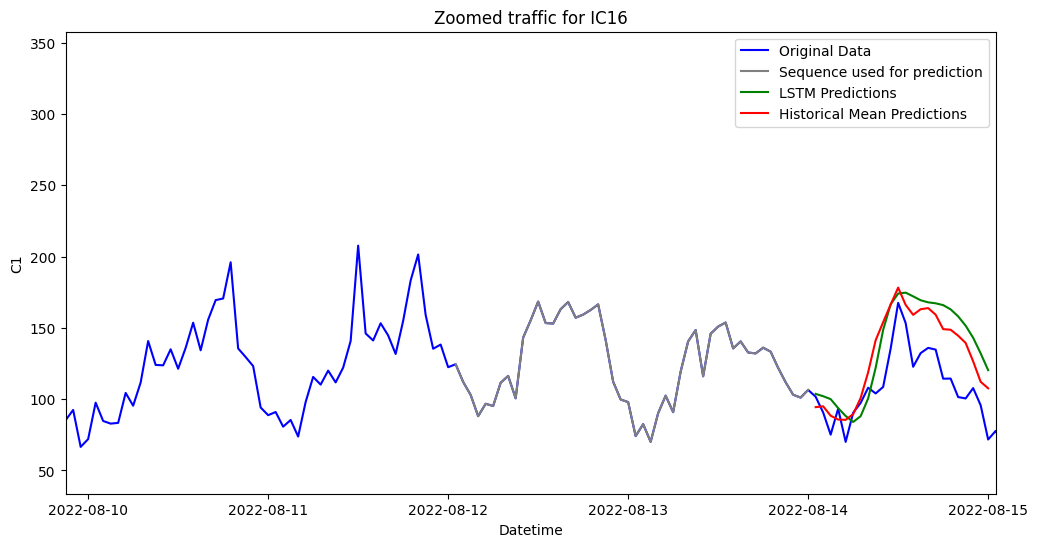

Epoch [100/2000], Loss: 0.009406317956745625
Epoch [200/2000], Loss: 0.005429893732070923
Epoch [300/2000], Loss: 0.004652887117117643
Epoch [400/2000], Loss: 0.004265639930963516
Epoch [500/2000], Loss: 0.004005444701761007
Epoch [600/2000], Loss: 0.003855376271530986
Epoch [700/2000], Loss: 0.0038198998663574457
Epoch [800/2000], Loss: 0.003682779148221016
Epoch [900/2000], Loss: 0.0036120282020419836
Epoch [1000/2000], Loss: 0.0035111710894852877
Epoch [1100/2000], Loss: 0.0034442972391843796
Epoch [1200/2000], Loss: 0.0033995171543210745
Epoch [1300/2000], Loss: 0.00331487855874002
Epoch [1400/2000], Loss: 0.0032663329038769007
Epoch [1500/2000], Loss: 0.0032183481380343437
Epoch [1600/2000], Loss: 0.003192201256752014
Epoch [1700/2000], Loss: 0.0031323435250669718
Epoch [1800/2000], Loss: 0.0031115177553147078
Epoch [1900/2000], Loss: 0.003007841994985938
Epoch [2000/2000], Loss: 0.0029524867422878742
Street: IC2 (Sacavém)
LSTM Model - Average Mean Absolute Error (MAE): 9.99760084

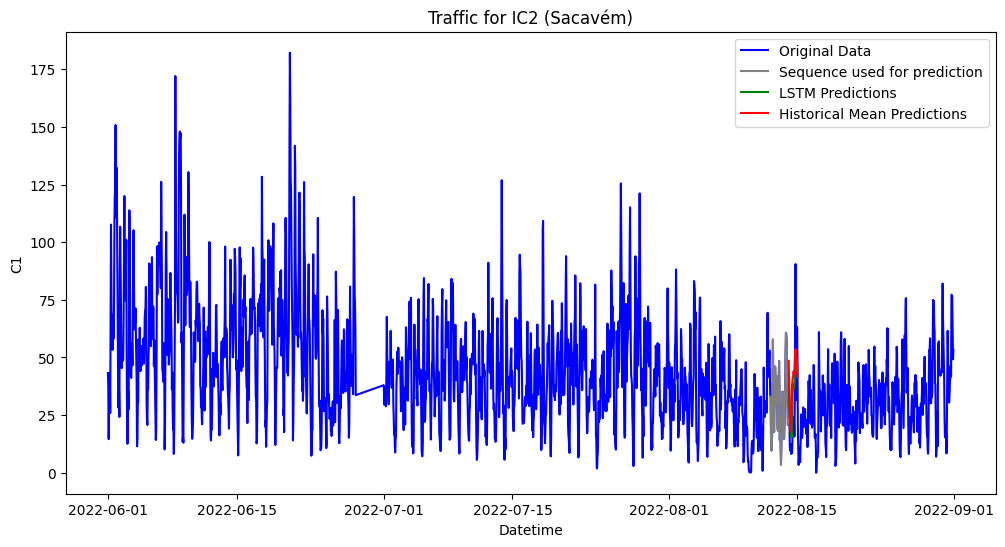

/tmp/ipykernel_11946/3514781035.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


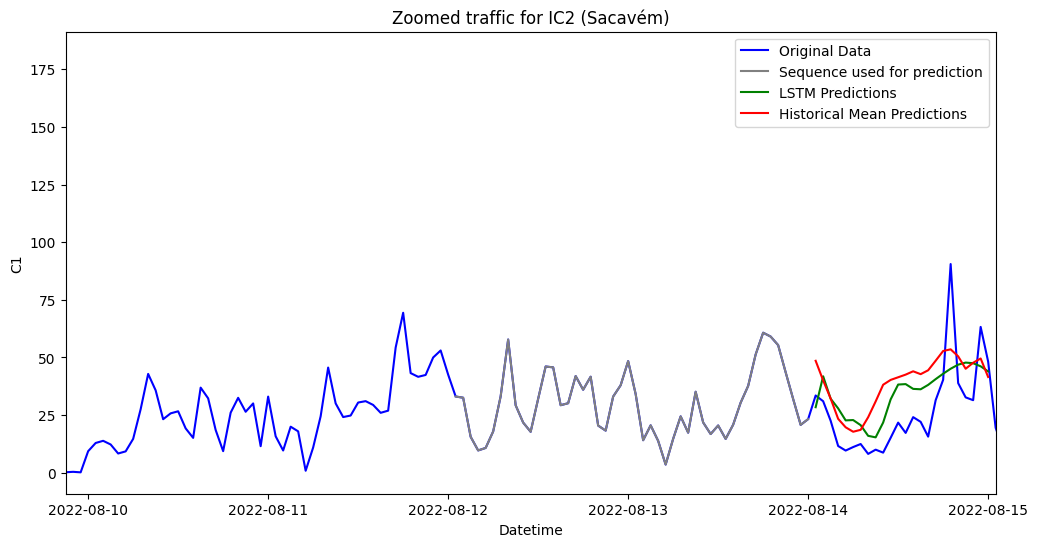

LSTM MAE: Mean = 19.90682485306265, Std = 10.264875796841467
LSTM RMSE: Mean = 24.633389027397442, Std = 12.339698031983119
Historical Mean MAE: Mean = 26.135253448324196, Std = 15.975170227954019
Historical Mean RMSE: Mean = 33.0089604810972, Std = 21.8891725410315


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define model parameters
INPUT_SIZE = 3
HIDDEN_SIZE = 30
OUTPUT_SIZE = 1  # Predicting one value (C1)
SEQUENCE_LENGTH = 48
NUM_EPOCHS = 2000
LEARNING_RATE = 0.001
TEST_SIZE = 0.2
RANDOM_STATE = 42
FUTURE = 24



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


def calculate_historical_mean(df):
    # Group by DayOfWeek and Hour, and calculate the mean of C1
    historical_mean = df.groupby(['DayOfWeek', 'Hour'])['C1'].mean()

    # Map the historical mean to the corresponding DayOfWeek and Hour
    df['HistoricalMean'] = df.apply(lambda row: historical_mean[row['DayOfWeek'], row['Hour']], axis=1)

    return df


def evaluate_historical_mean_model(df, test_size):
    # Split the data into training and test sets
    train_size = int(len(df) * (1 - test_size))
    train_df = df[:train_size]
    test_df = df[train_size:]

    # The predictions of the historical mean model are simply the 'HistoricalMean' column
    predictions = test_df['HistoricalMean'].values

    # The true values are the 'C1' column
    true_values = test_df['C1'].values

    # Calculate the MAE and RMSE
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    return mae, rmse

def create_sequences(data, day_of_week, hour, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = torch.cat([data[i:i+seq_length], day_of_week[i:i+seq_length], hour[i:i+seq_length]], dim=1)
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

def preprocess_data(df):


    # Resample the "C1" column for each hour and calculate the mean values
    df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

    # Create a new DataFrame with the mean values, Grid_ID, and Datetime
    resampled_df = pd.DataFrame({
        "Grid_ID": df["Grid_ID"].resample("H").first(),
        "Datetime": df_hourly_mean.index,
        "C1": df_hourly_mean
    })

    resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
    resampled_df["Hour"] = resampled_df["Datetime"].dt.hour

    day_of_week_values = resampled_df["DayOfWeek"].values
    day_of_week_tensor = torch.tensor(day_of_week_values, dtype=torch.float32).reshape(-1, 1)
    hour_values = resampled_df["Hour"].values
    hour_tensor = torch.tensor(hour_values, dtype=torch.float32).reshape(-1, 1)
    resampled_df = calculate_historical_mean(resampled_df)

    target_col = 'C1'
    target = resampled_df[target_col].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    target_scaled = scaler.fit_transform(target)
    target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


    # Define sequence length and create sequences
    sequences, labels = create_sequences(target_tensor, day_of_week_tensor, hour_tensor, SEQUENCE_LENGTH)
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)

    return X_train, X_test, y_train, y_test, target, scaler, resampled_df


def train_model(X_train, y_train):
    model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)

        loss = criterion(outputs.squeeze(), y_train.squeeze()) 
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item()}')

    return model

def evaluate_model(model, X_test, y_test, scaler):
    # Your evaluation code here
    model.eval()
    num_test_sequences = len(X_test) - FUTURE
    test_sequences = X_test[:num_test_sequences, :, :]
    predicted_sequences = []
    with torch.no_grad():
        for test_seq in test_sequences:
            base_seq = test_seq.unsqueeze(0).clone()
            predicted_seq = []
            next_day = base_seq[:, -1:, 1]
            for i in range(FUTURE):
                pred = model(base_seq)
                predicted_seq.append(pred.item())

                next_hour = (base_seq[:, -1:, 2] + 1) % 24
                if(next_hour == 0):
                    next_day = (base_seq[:, -1:, 1] + 1) % 7
            
                next_value = torch.cat([pred.unsqueeze(2), next_day.unsqueeze(2), next_hour.unsqueeze(2)], dim=2)  # Include hour tensor
                base_seq = torch.cat([base_seq[:, 1:, :], next_value], dim=1)
            # Inverse transform the values
            predicted_seq = np.array(predicted_seq).reshape(-1, 1)
            predicted_seq = scaler.inverse_transform(predicted_seq)
            predicted_sequences.append(predicted_seq)


    y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))
    mae_list = []
    rmse_list = []

    for i in range(num_test_sequences):
        y_t = y_test[i:i+FUTURE]
        predicted_seq = predicted_sequences[i]
        mae = mean_absolute_error(y_t, predicted_seq)
        rmse = np.sqrt(mean_squared_error(y_t, predicted_seq))

        mae_list.append(mae)
        rmse_list.append(rmse)

    average_mae = np.mean(mae_list)
    average_rmse = np.mean(rmse_list)

    
    return predicted_sequences, test_sequences, average_mae, average_rmse

def plot_results(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start, street_name):
    plt.figure(figsize=(12, 6))
    plt.plot(datetimes, target, label='Original Data', color='blue')
    plt.plot(datetimes[test_start - len(seq_used_pred):test_start],  np.array(seq_used_pred).reshape(-1, 1), label='Sequence used for prediction', color='gray')
    plt.plot(datetimes[test_start:test_start + FUTURE], predicted_sequences[0], label='LSTM Predictions', color='green')
    plt.plot(datetimes[test_start:test_start + FUTURE], historical_mean_predictions, label='Historical Mean Predictions', color='red')

    plt.xlabel('Datetime')
    plt.ylabel("C1")
    plt.title(f"Traffic for {street_name}")
    plt.legend()
    plt.show()

def plot_zoomed(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start, street_name,  zoom_range=100,):
    test_start = len(target) - len(y_test) +1

    plt.figure(figsize=(12, 6))
    plt.plot(datetimes, target, label='Original Data', color='blue')
    plt.plot(datetimes[test_start - len(seq_used_pred):test_start],  np.array(seq_used_pred).reshape(-1, 1), label='Sequence used for prediction', color='gray')
    plt.plot(datetimes[test_start:test_start + FUTURE], predicted_sequences[0], label='LSTM Predictions', color='green')
    plt.plot(datetimes[test_start:test_start + FUTURE], historical_mean_predictions, label='Historical Mean Predictions', color='red')

    # Zoom in on a smaller period of time
    plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])

    plt.xlabel('Datetime')
    plt.ylabel("C1")
    plt.title(f"Zoomed traffic for {street_name}")
    plt.legend()
    plt.show()


hist_mae_list = []
hist_rmse_list = []
lstm_mae_list = []
lstm_rmse_list = []
for ax, street_name in zip(axes.flatten(), street_names):
    street_df = entrance_roads_df[entrance_roads_df['street_name'] == street_name].copy()
    street_df.set_index('Datetime', inplace=True)
    X_train, X_test, y_train, y_test, target, scaler, resampled_df = preprocess_data(street_df)
    datetimes = resampled_df["Datetime"]
    model = train_model(X_train, y_train)
    predicted_sequences, test_sequences, average_mae, average_rmse = evaluate_model(model, X_test, y_test, scaler)
    print(f"Street: {street_name}")
    print(f"LSTM Model - Average Mean Absolute Error (MAE): {average_mae}")
    print(f"LSTM Model - Average Root Mean Squared Error (RMSE): {average_rmse}")
    lstm_mae_list.append(average_mae)
    lstm_rmse_list.append(average_rmse)

    # Evaluate the historical mean model
    historical_mean_mae, historical_mean_rmse = evaluate_historical_mean_model(resampled_df, TEST_SIZE)
    print(f"Historical Mean Model - Average Mean Absolute Error (MAE): {historical_mean_mae}")
    print(f"Historical Mean Model - Average Root Mean Squared Error (RMSE): {historical_mean_rmse}")
    hist_mae_list.append(historical_mean_mae)
    hist_rmse_list.append(historical_mean_rmse) 

    # Get the historical mean predictions
    test_start = len(target) - len(y_test) +1
    historical_mean_predictions = resampled_df['HistoricalMean'].values[test_start:test_start + FUTURE]

    seq_used_pred = scaler.inverse_transform(test_sequences[1, :,0].squeeze().reshape(-1, 1).clone())
    plot_results(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start, street_name)
    plot_zoomed(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start, street_name)

print(f"LSTM MAE: Mean = {np.mean(lstm_mae_list)}, Std = {np.std(lstm_mae_list)}")
print(f"LSTM RMSE: Mean = {np.mean(lstm_rmse_list)}, Std = {np.std(lstm_rmse_list)}")
print(f"Historical Mean MAE: Mean = {np.mean(hist_mae_list)}, Std = {np.std(hist_mae_list)}")
print(f"Historical Mean RMSE: Mean = {np.mean(hist_rmse_list)}, Std = {np.std(hist_rmse_list)}")
        

In [6]:

print(f"Average LSTM MAE: Mean = {np.mean(lstm_mae_list)}, Std = {np.std(lstm_mae_list)}")
print(f"Average Historical Mean MAE: Mean = {np.mean(hist_mae_list)}, Std = {np.std(hist_mae_list)}")
print(f"Average LSTM RMSE: Mean = {np.mean(lstm_rmse_list)}, Std = {np.std(lstm_rmse_list)}")
print(f"Average Historical Mean RMSE: Mean = {np.mean(hist_rmse_list)}, Std = {np.std(hist_rmse_list)}")


data = {
    'Street Name': street_names,
    'LSTM MAE': lstm_mae_list,
    'Historical Mean MAE': hist_mae_list,
    'LSTM RMSE': lstm_rmse_list,
    'Historical Mean RMSE': hist_rmse_list
}

df = pd.DataFrame(data)
df

Average LSTM MAE: Mean = 19.90682485306265, Std = 10.264875796841467
Average Historical Mean MAE: Mean = 26.135253448324196, Std = 15.975170227954019
Average LSTM RMSE: Mean = 24.633389027397442, Std = 12.339698031983119
Average Historical Mean RMSE: Mean = 33.0089604810972, Std = 21.8891725410315


,Street Name,LSTM MAE,Historical Mean MAE,LSTM RMSE,Historical Mean RMSE
0,Marginal,46.299918,68.692372,55.701673,95.812852
1,Ponte 25 Abril 102/103,14.608494,13.793050,18.889426,18.529402
2,A5,27.458813,32.724870,35.044995,40.377076
3,N117,16.559281,19.713196,21.759999,26.963798
4,IC19,17.270595,25.120643,21.532225,30.505744
5,A16,8.187426,10.910446,9.996746,12.952933
6,Calcada De Carriche,24.196844,45.945152,29.781379,52.962024
7,A1,25.657010,27.723534,31.152191,33.409475
8,A36,20.874532,22.016290,26.049076,28.619610
9,Ponte Vasco da Gama,6.670925,11.694196,8.228672,13.655337


### Experimenting with LSTM model

Several experiments were conducted to evaluate the performance of an LSTM model in predicting time series data. The LSTM model was employed to predict consecutive values of the C1 parameter, representing the number of distinct terminals in the grid. To clean the dataset, irrelevant columns were removed, and a specific grid (number 16) was chosen for experimentation. The C1 parameter was resampled to reflect the mean traffic in each hour and interpolated to address missing values.

Data transformation involved organizing it into sequences and labels suitable for LSTM training. Each sequence comprised 80 values, predicting one value. Subsequently, all sequences were divided into training and testing sets. The model underwent training and evaluation, wherein 100 consecutive values were predicted from a sequence in the test set to assess model performance.

The results are depicted in a line plot, illustrating the predicted values, original data, and the sequence used for prediction. Plot presents period of one month, with time step equal one hour. This plot aids in gauging the accuracy of LSTM predictions. Observably, there is room for potential enhancement, suggesting avenues for improvement. For instance, incorporating additional parameters for prediction, such as the day of the week or hour, could refine the model's performance. Tweaking the hyperparameters and trying with more data might make the results better. We'll give it a shot in the next steps. 


